# Visualize Results: Downstream Performance - "Fully Observed" Experiment

This notebook should answer the questions: *Does imputation lead to better downstream performances?*

## Notebook Structure 

* Application Scenario 2 - Downstream Performance  
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT = "fully_observed"

EXPERIMENT_PATH = Path(f"../data/experiments/cluster5/{EXPERIMENT}/")
ALTERATIVE_BASELINE_PATH = Path("../data/experiments/cluster5/alternative_baseline_aggregated.csv")
FIGURES_PATH = Path(f"../paper/figures/{EXPERIMENT}/")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

DOWNSTREAM_RESULT_TYPE = "downstream_performance_mean"
IMPUTE_RESULT_TYPE = "impute_performance_mean"

In [4]:
Path(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE).mkdir(parents=True, exist_ok=True)

## Import the data

In [5]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 27s, sys: 3.85 s, total: 1min 31s
Wall time: 1min 39s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,MAE,1.179853,1.120607,NaN,NaN,NaN
1,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,MSE,23.152042,10.959723,NaN,NaN,NaN
2,fully_observed,AutoKerasImputer,40922,MAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,1.425468,0.630841,NaN,NaN,NaN
3,fully_observed,AutoKerasImputer,40922,MAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.905889,0.471882,NaN,NaN,NaN
4,fully_observed,AutoKerasImputer,40922,MAR,0.30,single_all,gyro_y,impute_performance_std,MSE,13.756370,17.497516,NaN,NaN,NaN


In [6]:
na_impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]
na_impute_results.drop(["baseline", "corrupted", "imputed"], axis=1, inplace=True)
na_impute_results = na_impute_results[na_impute_results.isna().any(axis=1)]
na_impute_results.shape

(276, 11)

In [7]:
alt_base = pd.read_csv(ALTERATIVE_BASELINE_PATH)
alt_base.columns = ["experiment", "task", "pattern", "fraction", "metric", "mean", "std"]
alt_base = alt_base[2:]

alt_base["fraction"] = pd.to_numeric(alt_base["fraction"])
alt_base["mean"] = pd.to_numeric(alt_base["mean"])
alt_base["std"] = pd.to_numeric(alt_base["std"])

alt_base = alt_base[alt_base["experiment"] == "experiment_1"]  # experiment_1 == fully_observed
alt_base.drop(["experiment"], axis=1, inplace=True)

alt_base = alt_base[alt_base["metric"].isin([CLF_METRIC, REG_METRIC])]
alt_base

,task,pattern,fraction,metric,mean,std
2,6,MAR,0.01,F1_macro,0.719768,0.005019
5,6,MAR,0.10,F1_macro,0.681199,0.010442
8,6,MAR,0.30,F1_macro,0.620052,0.008216
11,6,MAR,0.50,F1_macro,0.584140,0.012922
14,6,MCAR,0.01,F1_macro,0.716854,0.003861
...,...,...,...,...,...,...
2473,42712,MCAR,0.50,RMSE,149.508573,6.428469
2476,42712,MNAR,0.01,RMSE,140.552618,1.824274
2479,42712,MNAR,0.10,RMSE,143.605894,1.512146
2482,42712,MNAR,0.30,RMSE,145.329939,3.325570


In [8]:
downstream_results = results[
    (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]

# remove experiments where imputation failed
downstream_results = downstream_results.merge(
    na_impute_results,
    how = "left",
    validate = "one_to_one",
    indicator = True,
    suffixes=("", "_imp"),
    on = ["experiment", "imputer", "task", "missing_type", "missing_fraction", "strategy", "column"]
)
downstream_results = downstream_results[downstream_results["_merge"]=="left_only"]

assert len(results["strategy"].unique()) == 1
downstream_results.drop(["experiment", "strategy", "result_type_imp", "metric_imp", "train", "test", "train_imp", "test_imp", "_merge"], axis=1, inplace=True)

downstream_results = downstream_results.rename(
    {
        "imputer": "Imputer",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "baseline": "Baseline",
        "corrupted": "Corrupted", 	
        "imputed": "Imputed"
    },
    axis = 1
)
print(downstream_results.shape)

# join alternative baseline
downstream_results = downstream_results.merge(
    alt_base,
    right_on = ["task", "pattern", "fraction", "metric"],
    left_on = ["Task", "Missing Type", "Missing Fraction", "metric"],
).drop(["task", "pattern", "fraction", "std"], axis=1)
downstream_results = downstream_results.rename(
    {"mean": "Corrupted_2"},
    axis=1
)

downstream_results

(5406, 10)


,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,Corrupted_2
0,AutoKerasImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735496,0.735575,0.706455
1,ModeImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.727407,0.727368,0.727368,0.706455
2,ForestImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.727407,0.727676,0.727678,0.706455
3,VAEImputer_0,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735405,0.735405,0.706455
4,KNNImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.727407,0.727755,0.727755,0.706455
...,...,...,...,...,...,...,...,...,...,...,...
5401,ModeImputer,1220,MAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.475763,0.475763,0.467619
5402,ForestImputer,1220,MAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.476523,0.476757,0.467619
5403,VAEImputer_0,1220,MAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.475959,0.475959,0.467619
5404,KNNImputer,1220,MAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.477082,0.477118,0.467619


### Check if results are complete

In [9]:
# should have equal length
downstream_results["Imputer"].value_counts(dropna=False)

KNNImputer          828
VAEImputer_0        828
VAEImputer_noise    828
ModeImputer         828
ForestImputer       819
AutoKerasImputer    720
GAINImputer         555
Name: Imputer, dtype: int64

### Robustness: check which imputers yielded `NaN`values

In [10]:
for col in downstream_results.columns:
    na_sum = downstream_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = downstream_results[col].isna()
        print(downstream_results.loc[na_idx, "Imputer"].value_counts(dropna=False))
        print("\n")

## Compute Downstream Performance relative to Baseline

In [11]:
clf_row_idx = downstream_results["metric"] == CLF_METRIC
reg_row_idx = downstream_results["metric"] == REG_METRIC

In [12]:
downstream_results["Improvement"] = (downstream_results["Imputed"] - downstream_results["Corrupted"]) / downstream_results["Baseline"]
downstream_results["Improvement_2"] = (downstream_results["Imputed"] - downstream_results["Corrupted_2"]) / downstream_results["Baseline"]
downstream_results.loc[reg_row_idx, "Improvement"] = downstream_results.loc[reg_row_idx, "Improvement"]  * -1
downstream_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,Corrupted_2,Improvement,Improvement_2
0,AutoKerasImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735496,0.735575,0.706455,0.000108,0.039585
1,ModeImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.727407,0.727368,0.727368,0.706455,0.000000,0.028750
2,ForestImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.727407,0.727676,0.727678,0.706455,0.000003,0.029177
3,VAEImputer_0,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.735632,0.735405,0.735405,0.706455,0.000000,0.039354
4,KNNImputer,40922,MAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.727407,0.727755,0.727755,0.706455,0.000000,0.029281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5401,ModeImputer,1220,MAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.475763,0.475763,0.467619,0.000000,0.017089
5402,ForestImputer,1220,MAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.476523,0.476757,0.467619,0.000492,0.019177
5403,VAEImputer_0,1220,MAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.475959,0.475959,0.467619,0.000000,0.017501
5404,KNNImputer,1220,MAR,0.10,keyword_id,downstream_performance_mean,F1_macro,0.476541,0.477082,0.477118,0.467619,0.000077,0.019934


## Application Scenario 2 - Downstream Performance

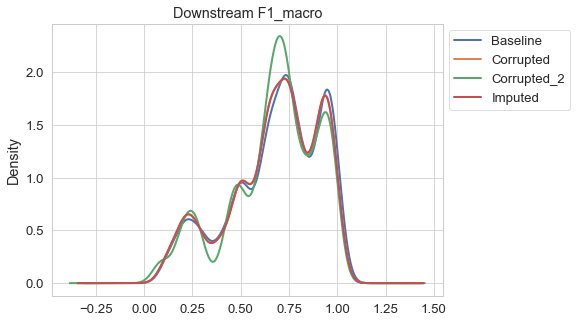

In [13]:
downstream_results.loc[clf_row_idx,["Baseline", "Corrupted", "Corrupted_2", "Imputed"]].plot(kind="kde", title=f"Downstream {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

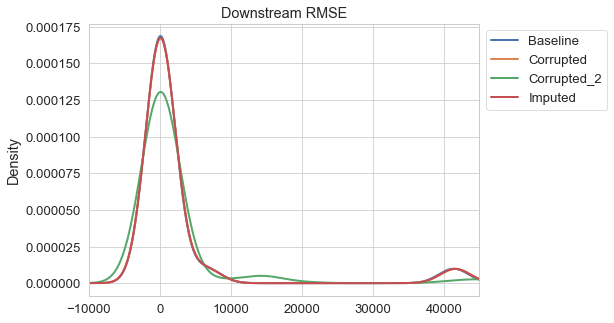

In [14]:
downstream_results.loc[reg_row_idx,["Baseline", "Corrupted", "Corrupted_2", "Imputed"]].plot(kind="kde", title=f"Downstream {REG_METRIC}", figsize=(7,5), xlim=(-10000, 45000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

### Categorical  Columns (Classification)

In [15]:
def draw_cat_box_plot(data, y, fname):
    ax = sns.catplot(
        x="Missing Fraction", 
        y=y,
        hue="Imputer", 
        #style="Imputer",
        col="Missing Type",
        data=data, 
        kind="box",
        height=6, 
        aspect=.8,)
    ax.set(ylim=(-0.25, 0.25))
    plt.savefig(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE/fname)

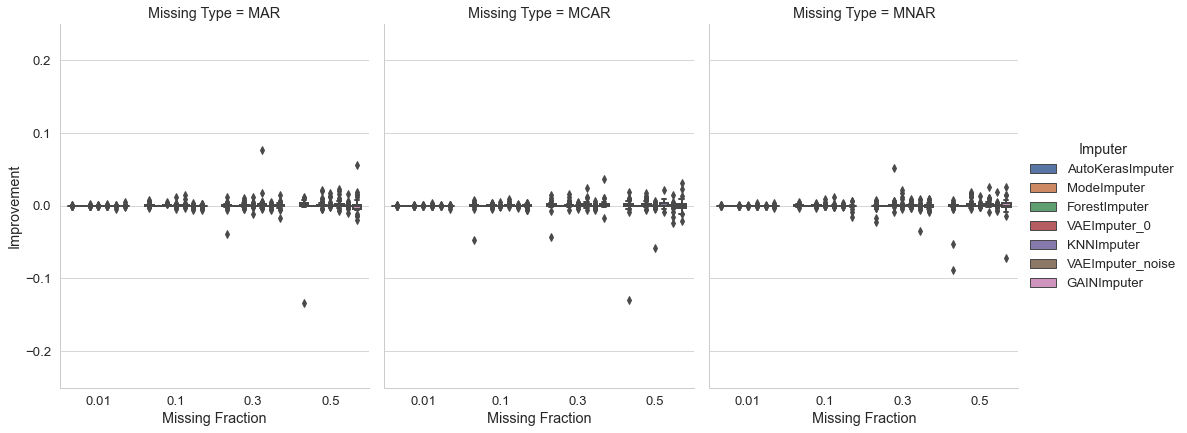

In [16]:
draw_cat_box_plot(
    downstream_results[clf_row_idx],
    "Improvement",
    f"categorical_{EXPERIMENT}.svg"
)

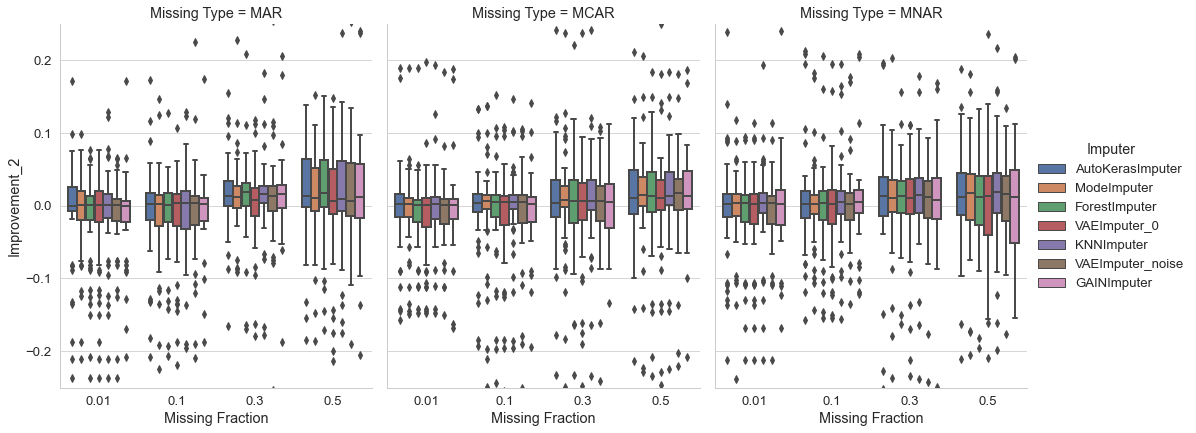

In [17]:
draw_cat_box_plot(
    downstream_results[clf_row_idx],
    "Improvement_2",
    f"categorical_{EXPERIMENT}_2.svg"
)

### Numerical Columns (Regression)

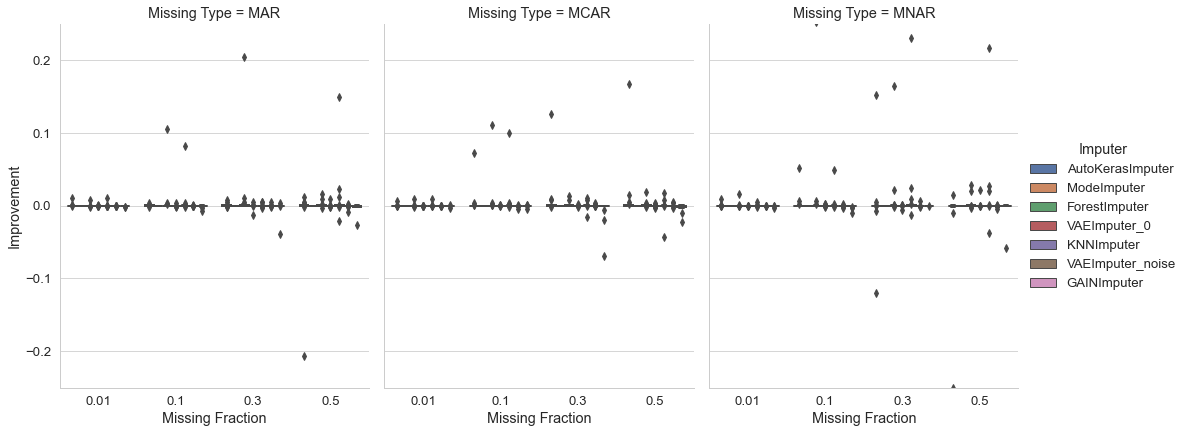

In [18]:
draw_cat_box_plot(
    downstream_results[reg_row_idx],
    "Improvement",
    f"numerical_{EXPERIMENT}.svg"
)

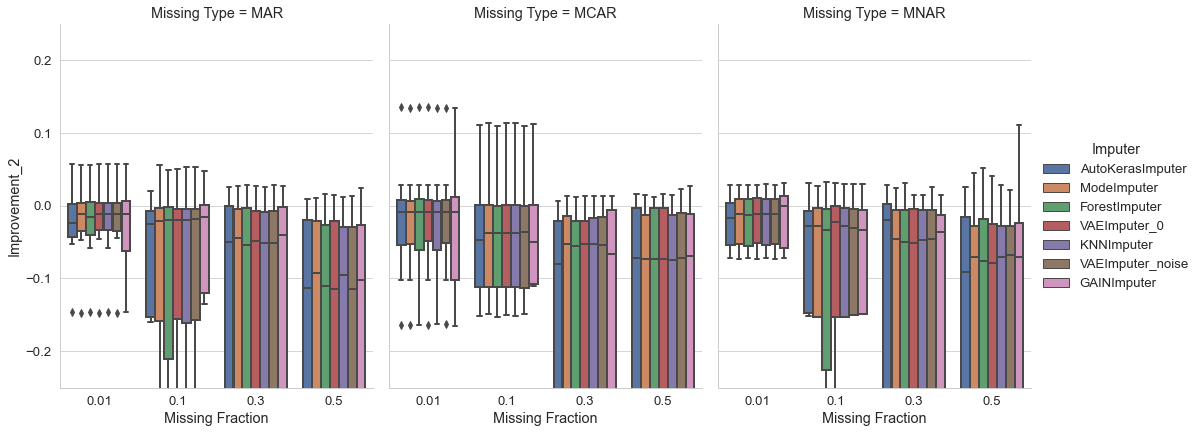

In [19]:
draw_cat_box_plot(
    downstream_results[reg_row_idx],
    "Improvement_2",
    f"numerical_{EXPERIMENT}_2.svg"
)

### Heterogenous Columns (Classification and Regression Combined)

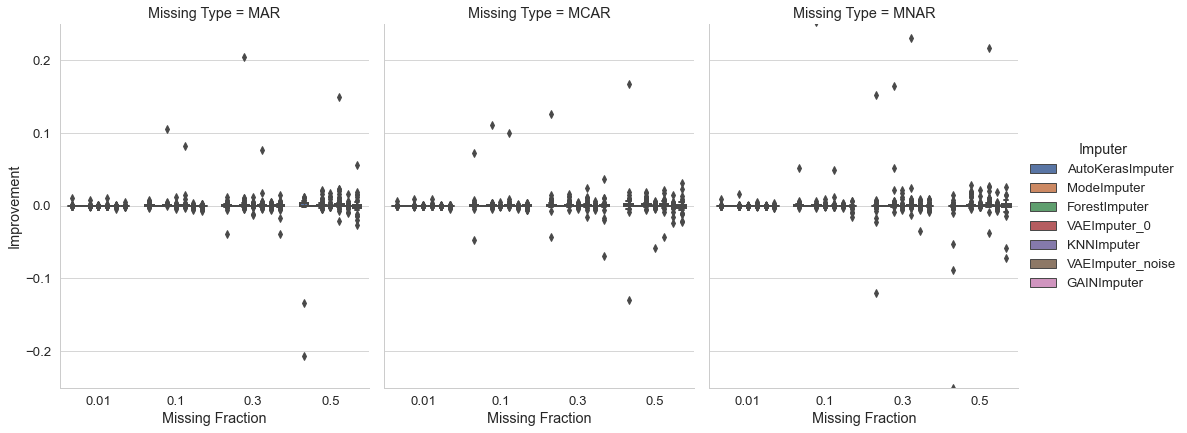

In [20]:
draw_cat_box_plot(
    downstream_results,
    "Improvement",
    f"heterogenous_{EXPERIMENT}.svg"
)

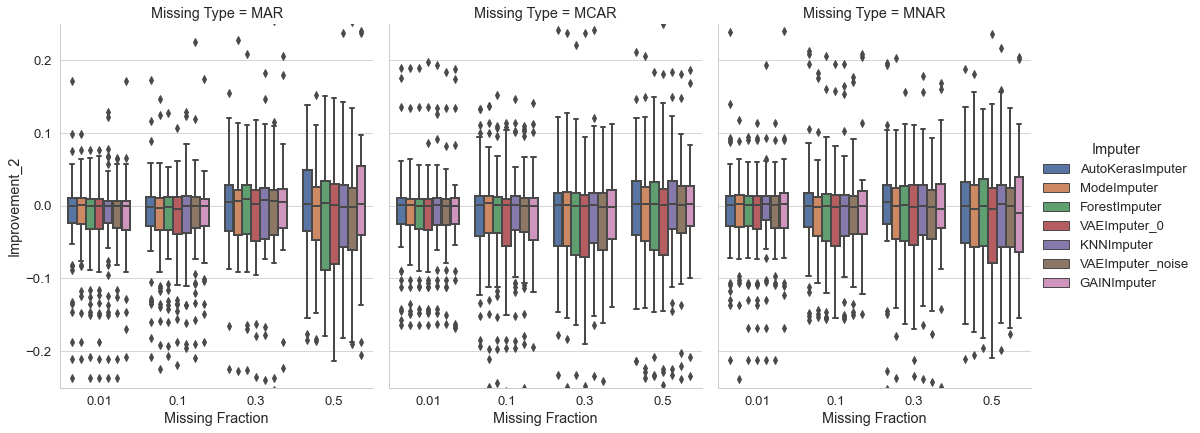

In [21]:
draw_cat_box_plot(
    downstream_results,
    "Improvement_2",
    f"heterogenous_{EXPERIMENT}_2.svg"
)